# Computer Systems 2016/17

### Practice 5 - Validation and parameter tuning

#### Once we have built our model, it is often a good idea to spend some time choosing appropriate hyperparameters, in order to squeeze the maximum possible performance. How do we archieve that?

#### We would like to optimize the performance of our model on the test set, so we could try various values for our hyperparameters and choose the best one. 

#### OVERFITTING WARNING!
#### The purpose of the test set is to evaluate the performance of a model using new data the model has not been trained on. If we chose the hyperparameters that give us the best result on the test set, we are leaking information from that set to our model. We might even overfit our hyperparameters on that data, resulting in an unexpected performance loss as soon as we deploy the model and new data comes.

#### We need a third dataset on which to train the hyperparameters, we call it Validation set

In [1]:
import pyspark
sc = pyspark.SparkContext('local[*]')

In [2]:
from urllib.request import urlretrieve
import zipfile

In [3]:
urlretrieve ("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "ml-100k.zip")

('ml-100k.zip', <http.client.HTTPMessage at 0x7f92846f2a20>)

In [4]:
dataFile = zipfile.ZipFile("ml-100k.zip")

URM_path = dataFile.extract("ml-100k/u.data")
URM = sc.textFile(URM_path)


def rowSplit (rowString):
    split = rowString.split("\t")
    result = tuple(split)
    return result


URM_tuple = URM.map(rowSplit)

URM_tuple.take(10)

[('196', '242', '3', '881250949'),
 ('186', '302', '3', '891717742'),
 ('22', '377', '1', '878887116'),
 ('244', '51', '2', '880606923'),
 ('166', '346', '1', '886397596'),
 ('298', '474', '4', '884182806'),
 ('115', '265', '2', '881171488'),
 ('253', '465', '5', '891628467'),
 ('305', '451', '3', '886324817'),
 ('6', '86', '3', '883603013')]

In [5]:
URM_training, URM_test, URM_validation = URM_tuple.randomSplit([0.6, 0.2, 0.2])

In [6]:
import scipy.sparse as sps
# pronounced “Sigh Pie”

# In case pip fails to install scipy you can install it by
# sudo apt-get install python-scipy

userList = URM_training.map(lambda x: int(x[0])).collect()
itemList = URM_training.map(lambda x: int(x[1])).collect()
ratingList = URM_training.map(lambda x: float(x[2])).collect()

numUsers = URM_training.map(lambda x: x[0]).distinct().count()
numItems = URM_training.map(lambda x: x[1]).distinct().count()

shape = (URM_training.map(lambda x: int(x[0])).max()+1,
         URM_training.map(lambda x: int(x[1])).max()+1)

URM_training_local = sps.csc_matrix((ratingList, (userList, itemList)), shape=shape)

In [7]:
similarity_local = URM_training_local.T.dot(URM_training_local)

similarity_local = similarity_local.tocoo()

similarity_local.setdiag(0.0)

similarity_local = similarity_local.tocsc()

In [8]:
userItems_train_dict = URM_training.map(lambda x: (int(x[0]), [x[1]])).reduceByKey(lambda x,y : x + y).collectAsMap()
userItems_test_dict = URM_test.map(lambda x: (int(x[0]), [x[1]])).reduceByKey(lambda x,y : x + y).collectAsMap()
userItems_validation_dict = URM_validation.map(lambda x: (int(x[0]), [x[1]])).reduceByKey(lambda x,y : x + y).collectAsMap()


user_id = 42
print("User {} saw {} items, some of them are: {}".
      format(user_id, len(userItems_train_dict[user_id]), userItems_train_dict[user_id][0:10]))

User 42 saw 117 items, some of them are: ['546', '274', '588', '44', '1028', '953', '685', '195', '69', '684']


In [9]:
import numpy as np

def filter_similarity_topK(similarity_all, k_value=50):

    values, rows, cols = [], [], []
    
    numItems = similarity_local.shape[0]

    for itemId in itemList:

        ### We take the row we need and transform it in a dense array
        currentItemSimilarity = similarity_all[itemId].toarray().ravel()

        idx_sorted = np.argsort(currentItemSimilarity)

        top_k_idx = idx_sorted[-k_value:]

        values.extend(currentItemSimilarity[top_k_idx])
        rows.extend(np.arange(numItems+1)[top_k_idx])
        cols.extend(np.ones(k_value) * itemId)

    similarity_topK = sps.csc_matrix((values, (rows, cols)), shape=(numItems, numItems), dtype=np.float32)
    
    return similarity_topK

In [10]:
import time

start_time = time.time()

similarity_topK = filter_similarity_topK(similarity_local, k_value=50)

print("Topk local selection takes {:.2f} seconds".format(time.time()-start_time))

similarity_topK

Topk local selection takes 136.17 seconds


<1681x1681 sparse matrix of type '<class 'numpy.float32'>'
	with 80600 stored elements in Compressed Sparse Column format>

In [16]:
def selectUserTopK (itemId, similarity_all, k_value):

    ### We take the row we need and transform it in a dense array
    currentItemSimilarity = similarity_all[itemId].toarray().ravel()

    idx_sorted = np.argsort(currentItemSimilarity)

    top_k_idx = idx_sorted[-k_value:]

    values = currentItemSimilarity[top_k_idx]

    rows = np.arange(numItems+1)[top_k_idx]

    cols = np.ones(k_value, dtype=np.int32) * itemId

    return list(zip(rows, cols, values))


    
def filter_similarity_topK_mapreduce(similarity_all, k_value=50):

    itemList_rdd = sc.parallelize(itemList)
    
    numItems = similarity_all.shape[0]

    similarity_topK_rdd = itemList_rdd.flatMap(lambda x: selectUserTopK(x, similarity_all, k_value))

    similarity_topK_rows = similarity_topK_rdd.map(lambda x: x[0]).collect()
    similarity_topK_cols = similarity_topK_rdd.map(lambda x: x[1]).collect()
    similarity_topK_values = similarity_topK_rdd.map(lambda x: x[2]).collect()

    similarity_topK = sps.csc_matrix((similarity_topK_values, (similarity_topK_rows, similarity_topK_cols)),
                                     shape=(numItems, numItems), dtype=np.float32)
    
    return similarity_topK


In [18]:
start_time = time.time()

similarity_topK = filter_similarity_topK_mapreduce(similarity_local, k_value=50)

print("Topk mapreduce selection takes {:.2f} seconds".format(time.time()-start_time))

similarity_topK

Topk mapreduce selection takes 119.46 seconds


<1681x1681 sparse matrix of type '<class 'numpy.float32'>'
	with 80600 stored elements in Compressed Sparse Column format>

#### We can see that mapreduce is slightly faster... the problem here is that we are collecting the data, which takes a lot of time

#### Also, the kind of parallelism we choose depends on what we are trying to do, basically if we want the fastest possible execution time for a task, or if we want to maximise the throughput

#### In a validation scenario it might be more efficent to limit the parallelism inside a single task, that is the train/test of a model with a certain hyperparameter value, and run in parallel different tasks.

In [19]:
def MAP(RankedList, PositiveItems, at=None):
    """
    Calculates MAP@__ 
    """
    
    RankedList = RankedList[:at]
    is_relevant = np.in1d(RankedList, PositiveItems, assume_unique=True)
    
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(len(is_relevant)))
    map_score = np.sum(p_at_k) / np.min([len(PositiveItems), len(RankedList)])
    
    assert 0 <= map_score <= 1, map_score
    
    return map_score


In [20]:
def getUserRelevantItems(user_id, userItemInteractions_dictionary):
    
    if(user_id in userItemInteractions_dictionary):
        return userItemInteractions_dictionary[user_id]
    
    else:
        return []


def filter_seen(user_id, ranking):
    
    user_profile = URM_training_local[user_id]
    seen = user_profile.indices
    unseen_mask = np.in1d(ranking, seen, assume_unique=True, invert=True)
    
    return ranking[unseen_mask]

    
def recommendItemBased(user_id, similarity, numberOfItemsToRecommend = 10, exclude_seen = True):
    
    user_profile = URM_training_local[user_id]
    scores = user_profile.dot(similarity).toarray().ravel()
    
    ranking = scores.argsort()[::-1]
    
    if exclude_seen:
        ranking = filter_seen(user_id, ranking)
        
    return ranking[:numberOfItemsToRecommend]


In [21]:
def calculateOverallMap(userList_rdd, similarity, userItemInteractions_dictionary, at=10):
    
    userList_rdd_map = userList_rdd.map(lambda x: MAP(recommendItemBased(x, similarity),
                                                      getUserRelevantItems(user_id, userItemInteractions_dictionary),
                                                      at=at))

    MAP_value = userList_rdd_map.sum()/userList_rdd_map.count()
    
    return MAP_value
    

In [23]:
result_dict = {}
userList_rdd = URM_training.map(lambda x: int(x[0])).distinct()
k_value_list = list(range(10,100,10))

resultMAP_train_list = []
resultMAP_test_list = []
resultMAP_validation_list = []


for k_value in k_value_list:
    
    start_time = time.time()
    
    #similarity_topK = filter_similarity_topK(similarity_local, k_value=k_value)
    similarity_topK = filter_similarity_topK_mapreduce(similarity_local, k_value=k_value)
    
    resultMAP_test = calculateOverallMap(userList_rdd, similarity_topK, userItems_test_dict)
    resultMAP_train = calculateOverallMap(userList_rdd, similarity_topK, userItems_train_dict)
    resultMAP_validation = calculateOverallMap(userList_rdd, similarity_topK, userItems_validation_dict)
    
    resultMAP_train_list.append(resultMAP_train)
    resultMAP_test_list.append(resultMAP_test)
    resultMAP_validation_list.append(resultMAP_validation)
    
    
    print("Evaluated k_value {}, MAP_train is {:.3f}, MAP_test is {:.3f}, MAP_valiation is {:.3f}. Processing time {:.2f} sec".
          format(k_value, resultMAP_train, resultMAP_test, resultMAP_validation, time.time()-start_time))


Evaluated k_value 10, MAP_train is 0.124, MAP_test is 0.067, MAP_valiation is 0.041. Processing time 118.39 sec
Evaluated k_value 20, MAP_train is 0.123, MAP_test is 0.063, MAP_valiation is 0.040. Processing time 121.99 sec
Evaluated k_value 30, MAP_train is 0.120, MAP_test is 0.063, MAP_valiation is 0.039. Processing time 123.31 sec
Evaluated k_value 40, MAP_train is 0.119, MAP_test is 0.067, MAP_valiation is 0.040. Processing time 124.97 sec
Evaluated k_value 50, MAP_train is 0.120, MAP_test is 0.065, MAP_valiation is 0.040. Processing time 128.94 sec
Evaluated k_value 60, MAP_train is 0.121, MAP_test is 0.066, MAP_valiation is 0.039. Processing time 131.49 sec
Evaluated k_value 70, MAP_train is 0.124, MAP_test is 0.065, MAP_valiation is 0.040. Processing time 133.62 sec
Evaluated k_value 80, MAP_train is 0.124, MAP_test is 0.065, MAP_valiation is 0.041. Processing time 136.20 sec
Evaluated k_value 90, MAP_train is 0.123, MAP_test is 0.064, MAP_valiation is 0.040. Processing time 135

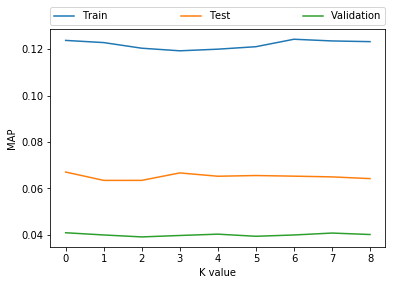

In [28]:
import matplotlib.pyplot as pyplot

pyplot.plot(resultMAP_train_list, label="Train")
pyplot.plot(resultMAP_test_list, label="Test")
pyplot.plot(resultMAP_validation_list, label="Validation")
pyplot.ylabel('MAP')
pyplot.xlabel('K value')

pyplot.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)

pyplot.show()